In [9]:
!pip install nltk
!pip install transformers
!pip install torch

In [20]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
import random
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
def encode_data(texts, labels, tokenizer, max_length=256):
    # Sicherstellen, dass die Eingaben Strings sind
    texts = [str(text) for text in texts]

    encoded = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',  # Empfohlenes Padding
        truncation=True,  # Explizite Trunkierung
        max_length=max_length,
        return_tensors='pt'
    )
    input_ids = encoded['input_ids']
    attention_masks = encoded['attention_mask']
    labels = torch.tensor(labels, dtype=torch.long)
    return TensorDataset(input_ids, attention_masks, labels)

In [13]:
def train_model(dataloader, model, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        outputs = model(**inputs)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    return total_loss / len(dataloader)

In [14]:
def evaluate(dataloader, model, device):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []
    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        with torch.no_grad():
            outputs = model(input_ids=batch[0], attention_mask=batch[1], labels=batch[2])
        loss = outputs[0]
        logits = outputs[1]
        total_loss += loss.item()
        predictions.append(logits.detach().cpu().numpy())
        true_labels.append(batch[2].detach().cpu().numpy())
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    return total_loss / len(dataloader), predictions, true_labels

In [15]:
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

## Bert-Modell mit alten Datensatz

In [ ]:
train_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/train_cleaned_rnn.csv")
test_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/test_cleaned_rnn.csv")

X = train_cleaned_data['tweet_cleaned'].values
y = train_cleaned_data['label'].values

X_test = test_cleaned_data['tweet_cleaned'].values
y_test = test_cleaned_data['label'].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Tokenizer initialisieren
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Daten vorbereiten
train_data = encode_data(X_train, y_train, tokenizer)
val_data = encode_data(X_val, y_val, tokenizer)
test_data = encode_data(X_test, y_test, tokenizer)


# DataLoader erstellen
batch_size = 32
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
val_dataloader = DataLoader(val_data, sampler=RandomSampler(val_data), batch_size=batch_size)
test_dataloader = DataLoader(test_data, sampler=RandomSampler(test_data), batch_size=batch_size)

# Modell initialisieren
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # Binäre Klassifikation
    output_attentions=False,
    output_hidden_states=False
)

# Optimizer und Scheduler einrichten
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 10
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * epochs
)

# Seed setzen
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
best_f1 = 0.0
best_model_path = 'drive/MyDrive/Colab Notebooks/models/bert/best_model'

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}")
    train_loss = train_model(train_dataloader, model, optimizer, scheduler, device)
    print(f"Training loss: {train_loss}")
    val_loss, predictions, true_labels = evaluate(val_dataloader, model, device)
    preds_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_labels.flatten()
    f1 = f1_score(labels_flat, preds_flat, average='weighted')
    print(f"Validation loss: {val_loss}")
    print(f"Validation F1 Score: {f1}")

    if f1 > best_f1:
        best_f1 = f1
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f"Best model saved with F1 Score: {best_f1}")

Epoch 1
Training loss: 0.16301239245607482
Validation loss: 0.12500057751700902
Validation F1 Score: 0.9515285123949945
Best model saved with F1 Score: 0.9515285123949945
Epoch 2
Training loss: 0.09803428683310733
Validation loss: 0.13281631817638603
Validation F1 Score: 0.9591253181811706
Best model saved with F1 Score: 0.9591253181811706
Epoch 3
Training loss: 0.059778017924531794
Validation loss: 0.15700911051317235
Validation F1 Score: 0.9595903984929232
Best model saved with F1 Score: 0.9595903984929232
Epoch 4
Training loss: 0.03815633134347523
Validation loss: 0.17466690804637133
Validation F1 Score: 0.9606743562169634
Best model saved with F1 Score: 0.9606743562169634
Epoch 5
Training loss: 0.025877704708402845
Validation loss: 0.18225022131446167
Validation F1 Score: 0.9621998018364227
Best model saved with F1 Score: 0.9621998018364227


In [ ]:
# Test-Evaluation
test_loss, predictions, true_labels = evaluate(test_dataloader, model, device)
preds_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_labels.flatten()
test_f1 = f1_score(labels_flat, preds_flat, average='weighted')
print(f"Test Loss: {test_loss}")
print(f"Test F1 Score: {test_f1}")

class_names = ["No Hate-Speech", "Hate-Speech"]
plot_confusion_matrix(labels_flat, preds_flat, class_names)

report = classification_report(labels_flat, preds_flat, target_names=class_names)

print("Classification Report:")
print(report)


### Bert-Modell mit neuen Datensatz

In [ ]:
new_train_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/new_train_cleaned_rnn.csv")
new_test_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/new_test_cleaned_rnn.csv")

X = new_train_cleaned_data['tweet_cleaned'].values
y = new_train_cleaned_data['label'].values

X_test = new_test_cleaned_data['tweet_cleaned'].values
y_test = new_test_cleaned_data['label'].values
print("HALLO")

In [ ]:
print("HALLO")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Tokenizer initialisieren
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Daten vorbereiten
train_data = encode_data(X_train, y_train, tokenizer)
val_data = encode_data(X_val, y_val, tokenizer)
test_data = encode_data(X_test, y_test, tokenizer)


# DataLoader erstellen
batch_size = 32
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
val_dataloader = DataLoader(val_data, sampler=RandomSampler(val_data), batch_size=batch_size)
test_dataloader = DataLoader(test_data, sampler=RandomSampler(test_data), batch_size=batch_size)

# Modell initialisieren
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # Binäre Klassifikation
    output_attentions=False,
    output_hidden_states=False
)

# Optimizer und Scheduler einrichten
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 5
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * epochs
)

# Seed setzen
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
best_f1 = 0.0
best_model_path = 'drive/MyDrive/Colab Notebooks/models/bert/best_model'

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}")
    train_loss = train_model(train_dataloader, model, optimizer, scheduler, device)
    print(f"Training loss: {train_loss}")
    val_loss, predictions, true_labels = evaluate(val_dataloader, model, device)
    preds_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_labels.flatten()
    f1 = f1_score(labels_flat, preds_flat, average='weighted')
    print(f"Validation loss: {val_loss}")
    print(f"Validation F1 Score: {f1}")

    if f1 > best_f1:
        best_f1 = f1
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f"Best model saved with F1 Score: {best_f1}")

Epoch 1
Training loss: 0.4038678589794371
Validation loss: 0.38015505127810145
Validation F1 Score: 0.8272896679583627
Epoch 2
Training loss: 0.3392757880974343
Validation loss: 0.3630652101207021
Validation F1 Score: 0.840132579318133
Epoch 3
Training loss: 0.28961239035910036
Validation loss: 0.38071238327570056
Validation F1 Score: 0.8369771924655043
Epoch 4
Training loss: 0.2432054909949804
Validation loss: 0.4199161558487528
Validation F1 Score: 0.8330953860977108
Epoch 5
Training loss: 0.20918425590716738
Validation loss: 0.4552268120837775
Validation F1 Score: 0.832117447654008


In [ ]:
# Test-Evaluation
test_loss, predictions, true_labels = evaluate(test_dataloader, model, device)
preds_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_labels.flatten()
test_f1 = f1_score(labels_flat, preds_flat, average='weighted')
print(f"Test Loss: {test_loss}")
print(f"Test F1 Score: {test_f1}")

class_names = ["No Hate-Speech", "Hate-Speech"]
plot_confusion_matrix(labels_flat, preds_flat, class_names)

report = classification_report(labels_flat, preds_flat, target_names=class_names)

print("Classification Report:")
print(report)


### Bert-Modell mit mixed Datensatz

In [16]:
# mixed_train_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/mixed_train_cleaned_rnn.csv")
# mixed_test_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/mixed_test_cleaned_rnn.csv")
mixed_train_cleaned_data = pd.read_csv("../data/mixed_dataset/train_cleaned.csv")
mixed_test_cleaned_data = pd.read_csv("../data/mixed_dataset/test_cleaned.csv")

mixed_train_cleaned_data = mixed_train_cleaned_data[mixed_train_cleaned_data.tweet_cleaned.notna()]
mixed_test_cleaned_data = mixed_test_cleaned_data[mixed_test_cleaned_data.tweet.notna() & mixed_test_cleaned_data.tweet_cleaned.notna()]

X = mixed_train_cleaned_data['tweet_cleaned'].values
y = mixed_train_cleaned_data['label'].values

X_test = mixed_test_cleaned_data['tweet_cleaned'].values
y_test = mixed_test_cleaned_data['label'].values

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Tokenizer initialisieren
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Daten vorbereiten
train_data = encode_data(X_train, y_train, tokenizer)
val_data = encode_data(X_val, y_val, tokenizer)
test_data = encode_data(X_test, y_test, tokenizer)


# DataLoader erstellen
batch_size = 32
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
val_dataloader = DataLoader(val_data, sampler=RandomSampler(val_data), batch_size=batch_size)
test_dataloader = DataLoader(test_data, sampler=RandomSampler(test_data), batch_size=batch_size)

# Modell initialisieren
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # Binäre Klassifikation
    output_attentions=False,
    output_hidden_states=False
)

# Optimizer und Scheduler einrichten
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 10
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * epochs
)

# Seed setzen
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [18]:
best_recall = 0.0
best_model_path = '../data/model/imran/mixed_dataset'
threshold = 0.3  # Beispiel: Niedrigere Schwelle erhöht Recall

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}")
    train_loss = train_model(train_dataloader, model, optimizer, scheduler, device)
    print(f"Training loss: {train_loss}")
    
    val_loss, predictions, true_labels = evaluate(val_dataloader, model, device)
    preds_flat = (predictions[:, 1] > threshold).astype(int)
    labels_flat = true_labels.flatten()

    recall = recall_score(labels_flat, preds_flat, pos_label=1, average="binary")
    
    print(f"Validation loss: {val_loss}")
    print(f"Validation Recall (Klasse 1): {recall}")

    if recall >= best_recall:  # Speichert auch, wenn Recall gleich bleibt
        best_recall = recall
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f"Best model saved with Recall (Klasse 1): {best_recall}")

print(f"Final best Recall: {best_recall}")

Epoch 1
Training loss: 0.3628228325431016
Validation loss: 0.3306587591844921
Validation Recall (Klasse 1): 0.11437613019891502
Best model saved with Recall (Klasse 1): 0.11437613019891502
Epoch 2
Training loss: 0.3092276137870024
Validation loss: 0.32718702549270046
Validation Recall (Klasse 1): 0.3779385171790235
Best model saved with Recall (Klasse 1): 0.3779385171790235
Epoch 3
Training loss: 0.2668126687178087
Validation loss: 0.34521489318770665
Validation Recall (Klasse 1): 0.5081374321880651
Best model saved with Recall (Klasse 1): 0.5081374321880651
Epoch 4
Training loss: 0.2221192964421147
Validation loss: 0.3783100246024939
Validation Recall (Klasse 1): 0.5
Epoch 5
Training loss: 0.18080436450391596
Validation loss: 0.4226175821046733
Validation Recall (Klasse 1): 0.4511754068716094
Epoch 6
Training loss: 0.1461198733869584
Validation loss: 0.49449001089669764
Validation Recall (Klasse 1): 0.4258589511754069
Epoch 7
Training loss: 0.120491345960866
Validation loss: 0.5915328

Test Loss: 1.0719733870471218
Test Precision: 0.6783, Test Recall: 0.6404, Test F1 Score: 0.8095


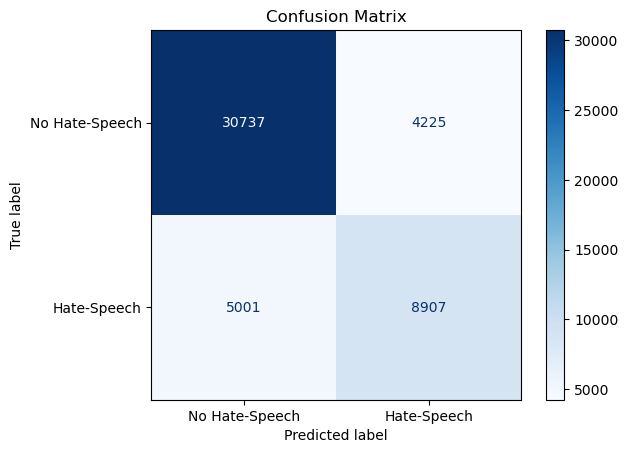

Classification Report:
                precision    recall  f1-score   support

No Hate-Speech       0.86      0.88      0.87     34962
   Hate-Speech       0.68      0.64      0.66     13908

      accuracy                           0.81     48870
     macro avg       0.77      0.76      0.76     48870
  weighted avg       0.81      0.81      0.81     48870



In [22]:
# Test-Evaluation
test_loss, predictions, true_labels = evaluate(test_dataloader, model, device)

# Wende den gleichen Threshold wie in der Validierung an
threshold = 0.3
preds_flat = (predictions[:, 1] > threshold).astype(int)  # Klasse 1 Vorhersage mit Schwelle
labels_flat = true_labels.flatten()

# Berechnung der Metriken
test_f1 = f1_score(labels_flat, preds_flat, average="weighted")
test_precision = precision_score(labels_flat, preds_flat, average="binary")
test_recall = recall_score(labels_flat, preds_flat, average="binary")

print(f"Test Loss: {test_loss}")
print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}")

class_names = ["No Hate-Speech", "Hate-Speech"]
plot_confusion_matrix(labels_flat, preds_flat, class_names)

report = classification_report(labels_flat, preds_flat, target_names=class_names, zero_division=0)
print("Classification Report:")
print(report)
